In [40]:
import os
import pandas as pd
import numpy as np
import time, gc
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pretrainedmodels
from argparse import Namespace
from sklearn.utils import shuffle
from apex import amp
from sklearn.model_selection import StratifiedKFold
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as albu
import PIL

In [41]:
DATA_DIR = '/mnt/chicm/data/bengali'
train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test.csv')
class_map_df = pd.read_csv(f'{DATA_DIR}/class_map.csv')
sample_sub_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')

In [42]:
df = pd.read_parquet(f'{DATA_DIR}/train_image_data_0.parquet')
df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [43]:
HEIGHT = 137
WIDTH = 236

def get_img(img_idx):
    return 255 - df.iloc[img_idx].values[1:].reshape(HEIGHT, WIDTH).astype(np.uint8)
    #return df.iloc[img_idx].values[1:].reshape(HEIGHT, WIDTH).astype(np.uint8)

In [44]:
def get_imgs(n=8):
    return [get_img(i) for i in range(n)]    

In [45]:
def get_img_tensor(img_idx):
    img = get_img(img_idx)
    return transforms.functional.to_tensor(img)

In [46]:
def get_img_batch(batch_size=8):
    imgs = []
    for i in range(batch_size):
        imgs.append(get_img_tensor(i))
    return torch.stack(imgs, 0)

In [47]:
def show_imgs(imgs, titles=None):
    n = len(imgs)
    plt.figure(figsize=(30, 20))
    columns = 4
    for i, img in enumerate(imgs):
        plt.subplot(n / columns + 1, columns, i + 1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img)

In [48]:
def show_img_batch(img):
    show_imgs([transforms.functional.to_pil_image(img[i]) for i in range(len(img))])

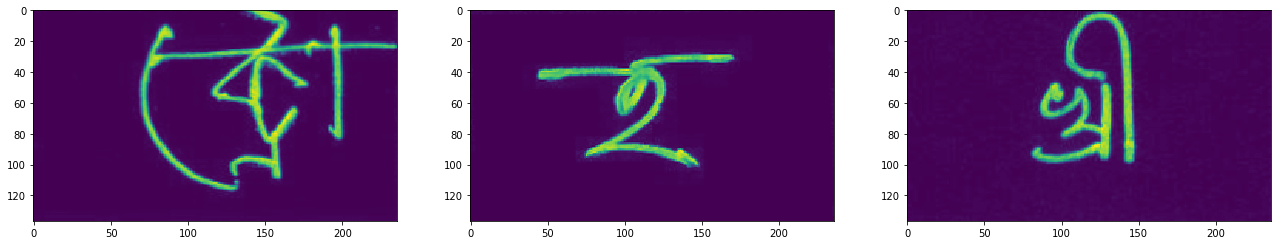

In [49]:
show_imgs([get_img(0), get_img(1), get_img(2)])

In [50]:
x = get_img_tensor(0)

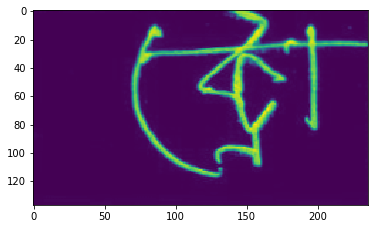

In [51]:
plt.imshow(transforms.functional.to_pil_image(x))

In [52]:
x = get_img_batch()
x.size()

torch.Size([8, 1, 137, 236])

# Cutmix cvcore

In [53]:
def crop_image_from_gray(img,tol=50):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def cutmix_data(inputs, alpha=1.):
    """
    Returns cut-mixed inputs, pairs of targets, and lambda.
    """
    bsize, _, h, w = inputs.shape
    shuffled_idxs = torch.randperm(bsize).cuda()

    inputs_s = inputs[shuffled_idxs]
    inputs_s = inputs_s.detach().cpu().numpy()
    inputs_s = (inputs_s * 255).astype(np.uint8)
    for i in range(inputs_s.shape[0]):
        img = inputs_s[i, 0, :, :]
        try:
            crop_img = crop_image_from_gray(255-img)
            crop_img = cv2.resize(crop_img, (inputs_s.shape[-1],inputs_s.shape[-2]), cv2.INTER_LINEAR)
        except:
            crop_img = img
        inputs_s[i,0,:,:] = crop_img / 255
    inputs_s = torch.tensor(inputs_s).float().cuda()
    lamb = np.random.beta(alpha + 1., alpha)

    rx = np.random.randint(w)
    ry = np.random.randint(h)
    cut_ratio = np.sqrt(1. - lamb)
    rw = np.int(cut_ratio * w)
    rh = np.int(cut_ratio * h)

    x1 = np.clip(rx - rw // 2, 0, w)
    x2 = np.clip(rx + rw // 2, 0, w)
    y1 = np.clip(ry - rh // 2, 0, h)
    y2 = np.clip(ry + rh // 2, 0, h)

    inputs[:, :, x1:x2, y1:y2] = inputs_s[:, :, x1:x2, y1:y2]
    return inputs


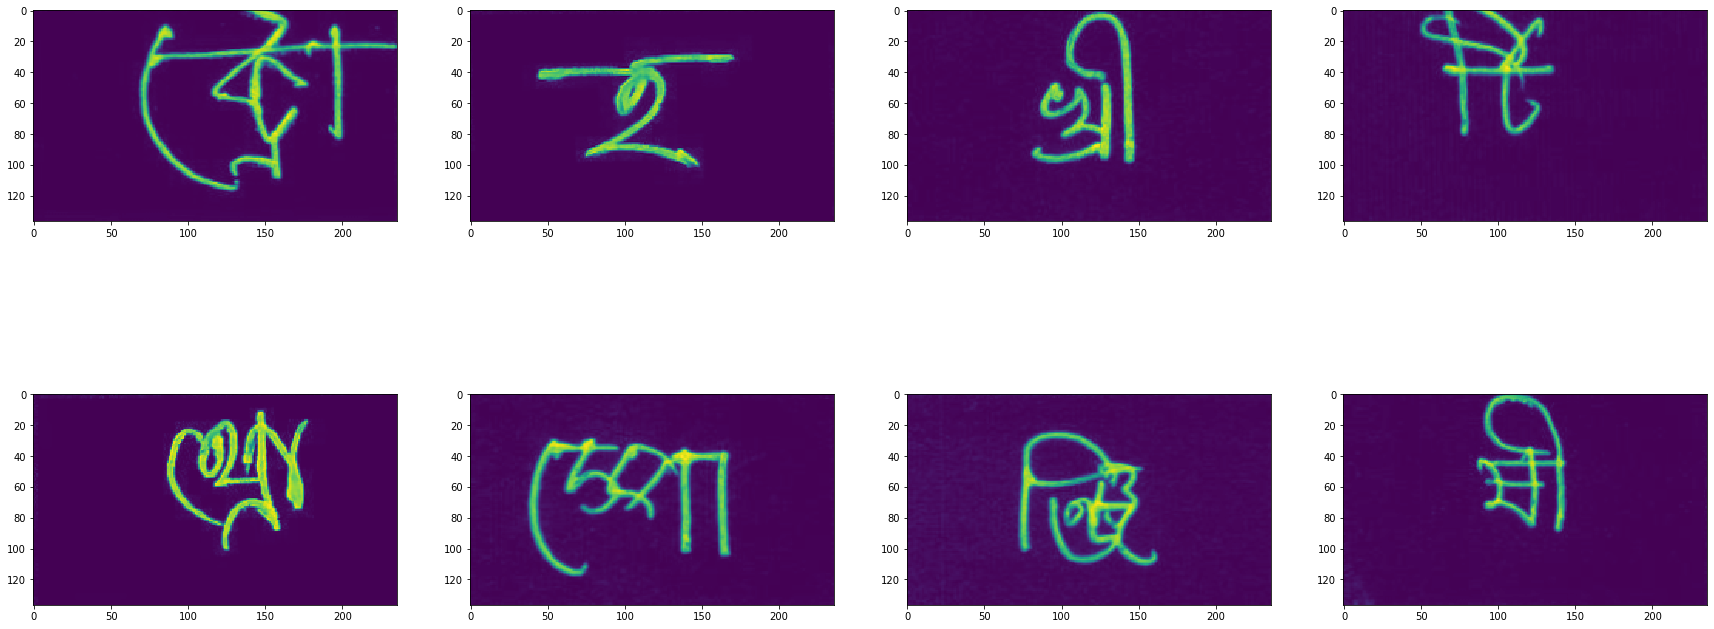

In [54]:
x = get_img_batch()
show_imgs([transforms.functional.to_pil_image(x[i]) for i in range(len(x))])

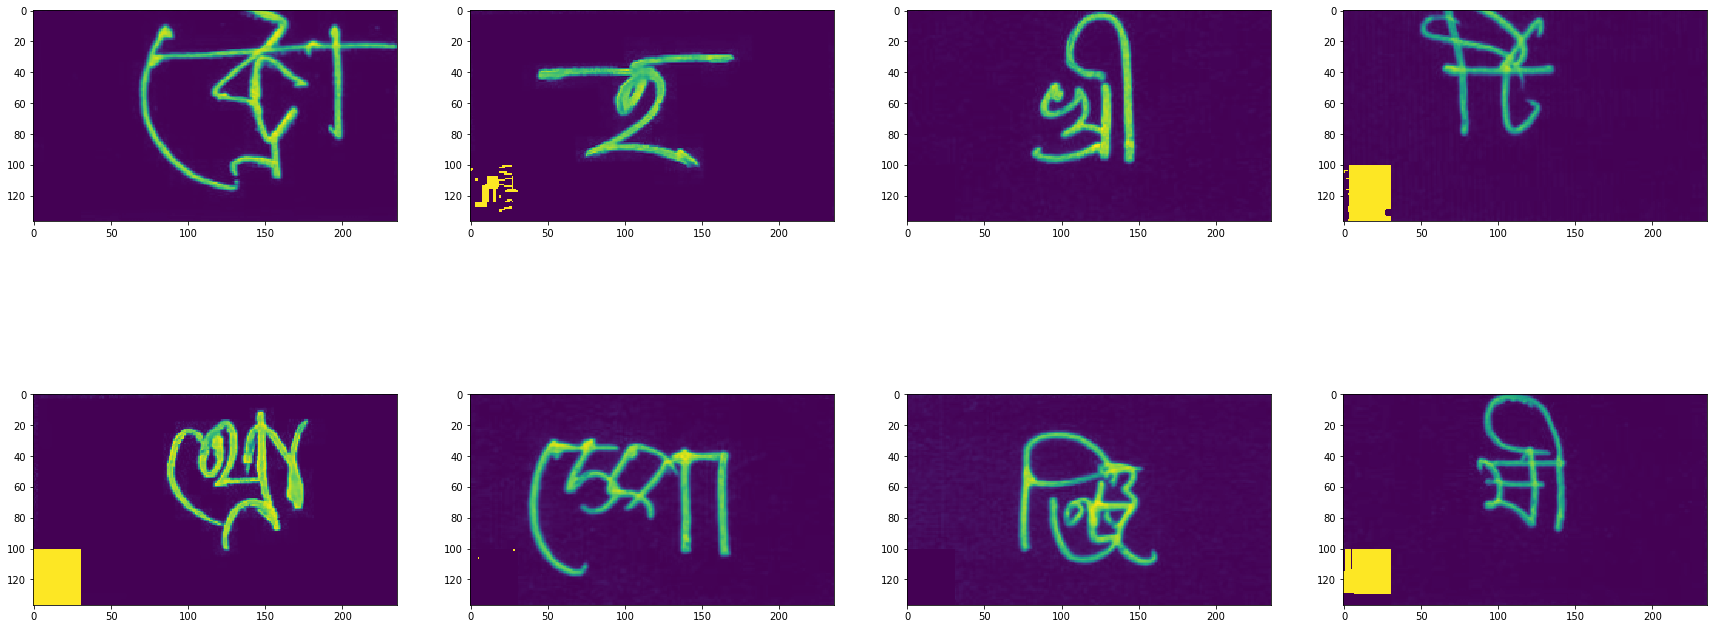

In [55]:
#plt.imshow(transforms.functional.to_pil_image(x[5]))
mixed = cutmix_data(x, alpha=1.5)
show_imgs([transforms.functional.to_pil_image(mixed[i]) for i in range(len(x))])

# Albumentations

In [56]:
def get_train_augs(p=1.):
    return albu.Compose([
        #albu.HorizontalFlip(.5),
        albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5 ),
        albu.Blur(blur_limit=3, p=0.3),
        albu.OpticalDistortion(p=0.3),
        albu.GaussNoise(p=0.3),
        albu.GridDistortion(p=1.),
        #albu.HueSaturationValue(p=.33) # not for grey scale
    ], p=p)
augs = get_train_augs()

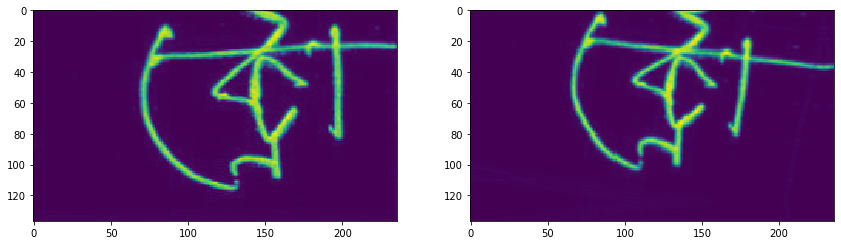

In [57]:
img = get_img(0)
img_aug = augs(image=img)['image']
show_imgs([img, img_aug])

# Gridmask

In [58]:
from gridmask import GridMask
grid = GridMask(64, 128, rotate=15)

In [59]:
img = get_img_tensor(1).unsqueeze(0).cuda()
x = grid(img)

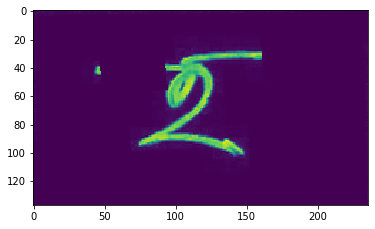

In [60]:
plt.imshow(transforms.functional.to_pil_image(x[0].cpu()))

In [61]:
np.random.randint(10)

4

In [62]:
x.shape

torch.Size([1, 1, 137, 236])

# Cutmix chicm

In [63]:
def rand_bbox(size, lam):
    H = size[2]
    W = size[3]

    x_margin_rate = 0.2

    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * (1-x_margin_rate*2) * cut_rat)
    cut_h = np.int(H * cut_rat)
    
    min_x_center = np.int(W * x_margin_rate + cut_w / 2)
    max_x_center = np.int(W * (1-x_margin_rate) - cut_w / 2)
    #print(min_x_center, max_x_center, lam, cut_w)
    min_y_center = cut_h // 2
    max_y_center = H - cut_h // 2
    if max_y_center == min_y_center:
        max_y_center += 1

    # uniform
    cx = np.random.randint(min_x_center, max_x_center)
    cy = np.random.randint(min_y_center, max_y_center)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    #print(bbx1, bbx2, bby1, bby2)

    return bbx1, bby1, bbx2, bby2

In [64]:
def cutmix(img, beta=1.):
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(img.size()[0]).cuda()
    #target_a = targets
    #target_b = targets[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
    img[:, :, bby1:bby2, bbx1:bbx2] = img[rand_index, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
    # compute output
    return img, lam


In [77]:
img = get_img_batch(8)

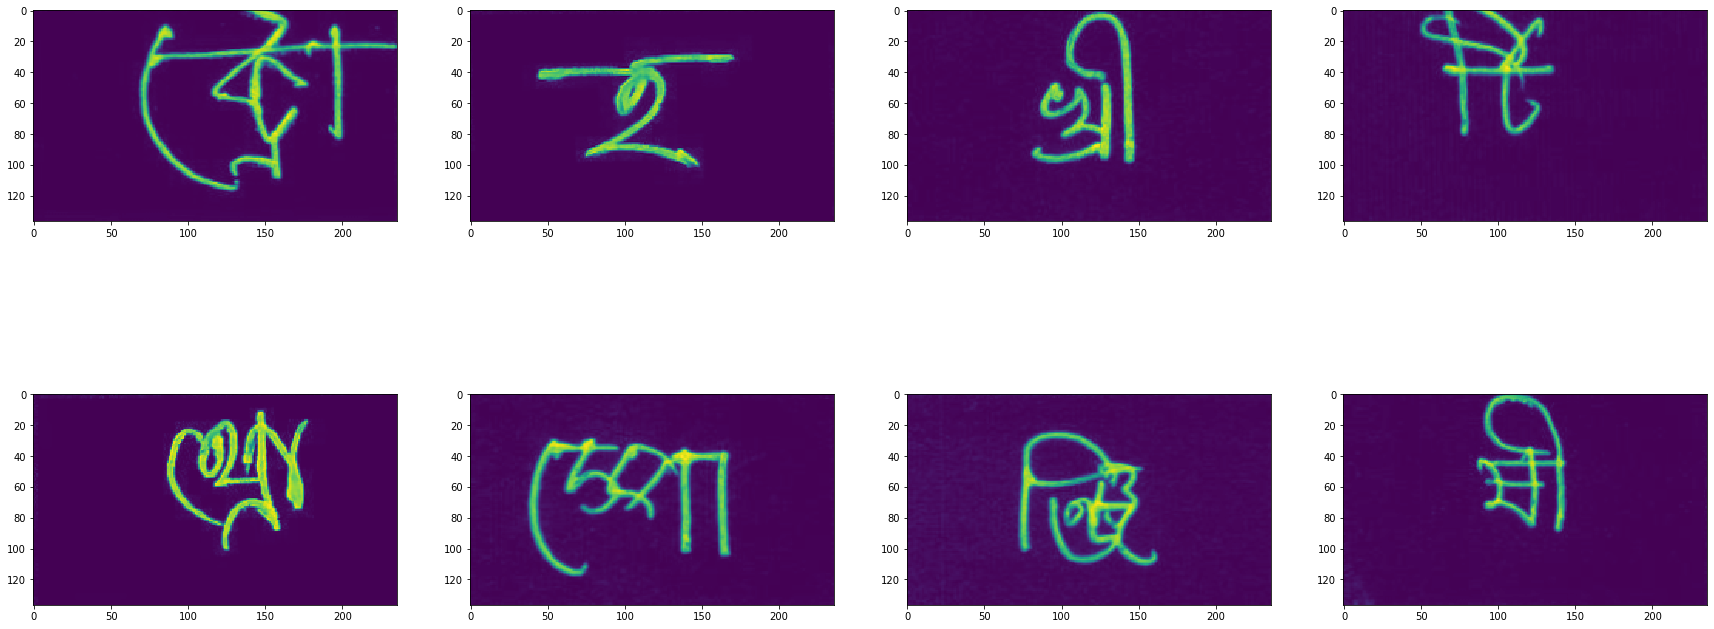

In [78]:
show_img_batch(img)

In [81]:
#for i in range(1000):
mixed, lamb = cutmix(img)

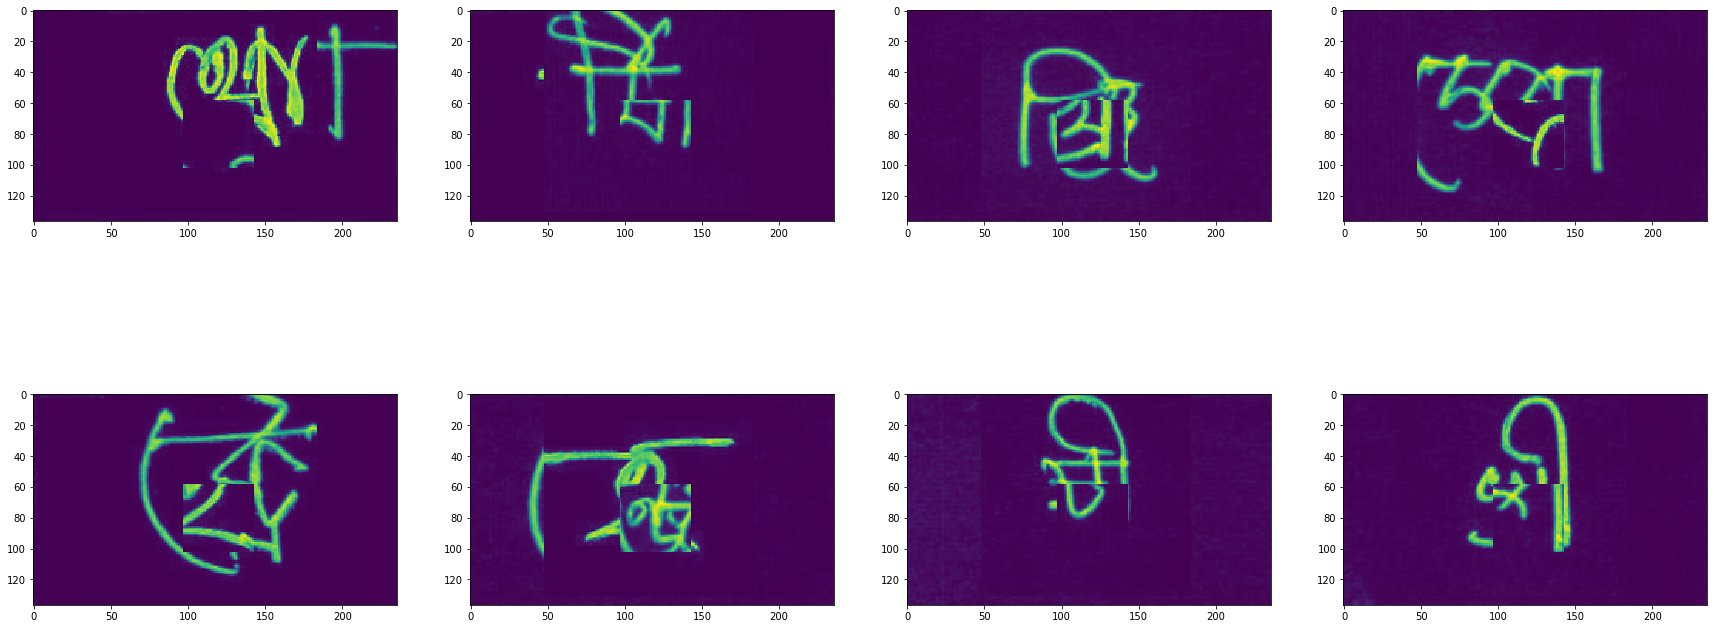

In [82]:
show_img_batch(mixed)

In [69]:
lamb

0.9997525671161698

In [70]:
np.random.beta(1.5, 1.5)

0.04122184854028824

In [71]:
img.size()

torch.Size([8, 1, 137, 236])

In [72]:
np.random.randint(10,12)

11

# AugMix

In [73]:
from augmix import RandomAugMix

In [74]:
aug = albu.Compose([
    RandomAugMix(severity=3, width=3, alpha=1., p=1.),
])

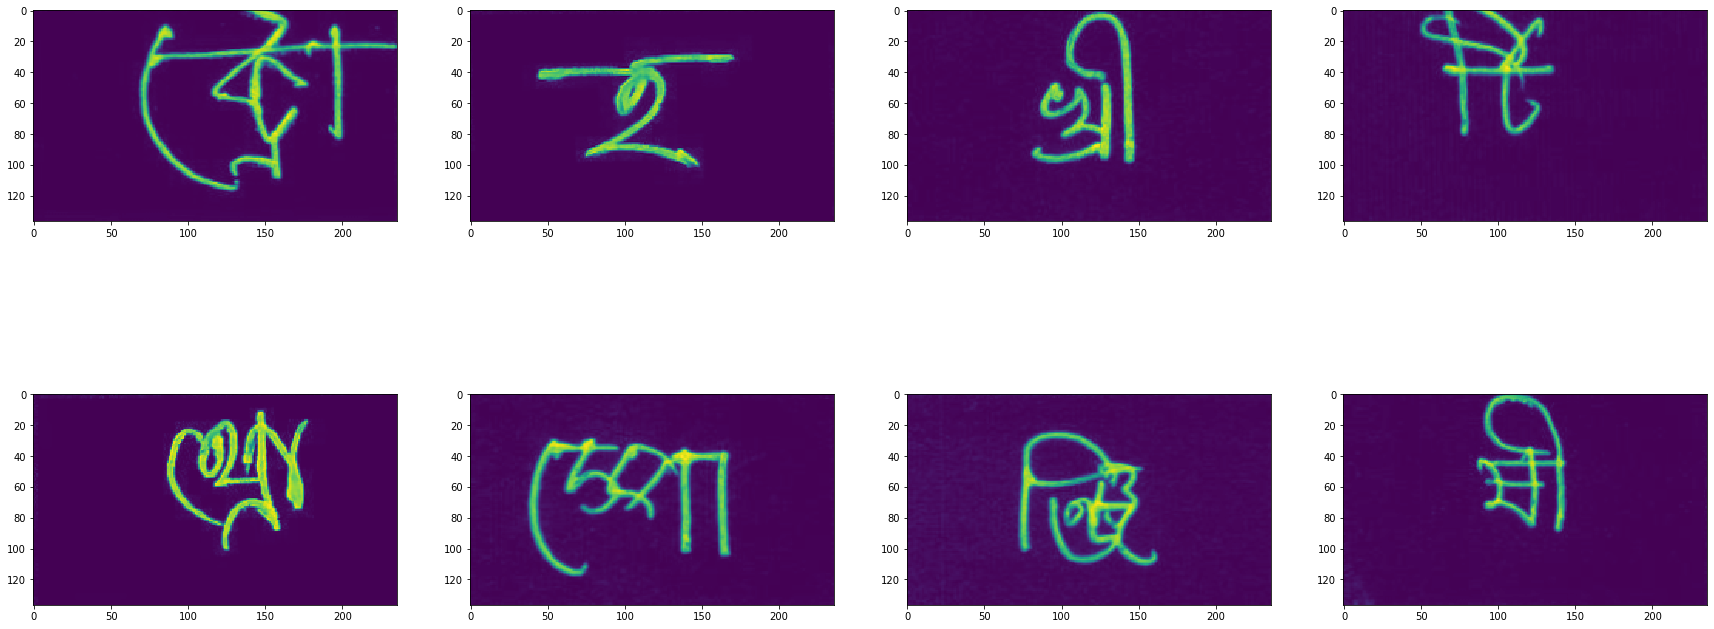

In [75]:
imgs = get_imgs(8)
show_imgs(imgs)

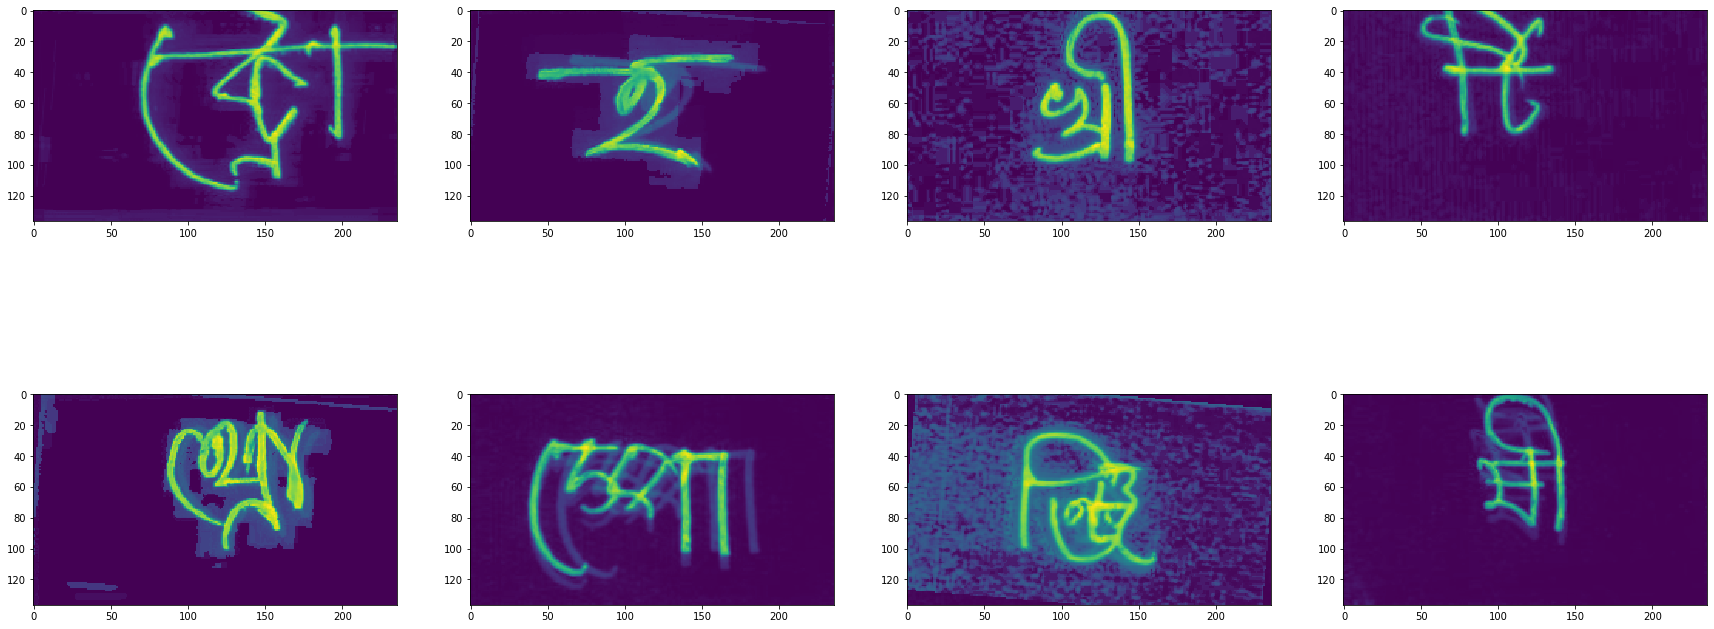

In [83]:
aug_imgs = [aug(image=img)['image'] for img in imgs]
show_imgs(aug_imgs)

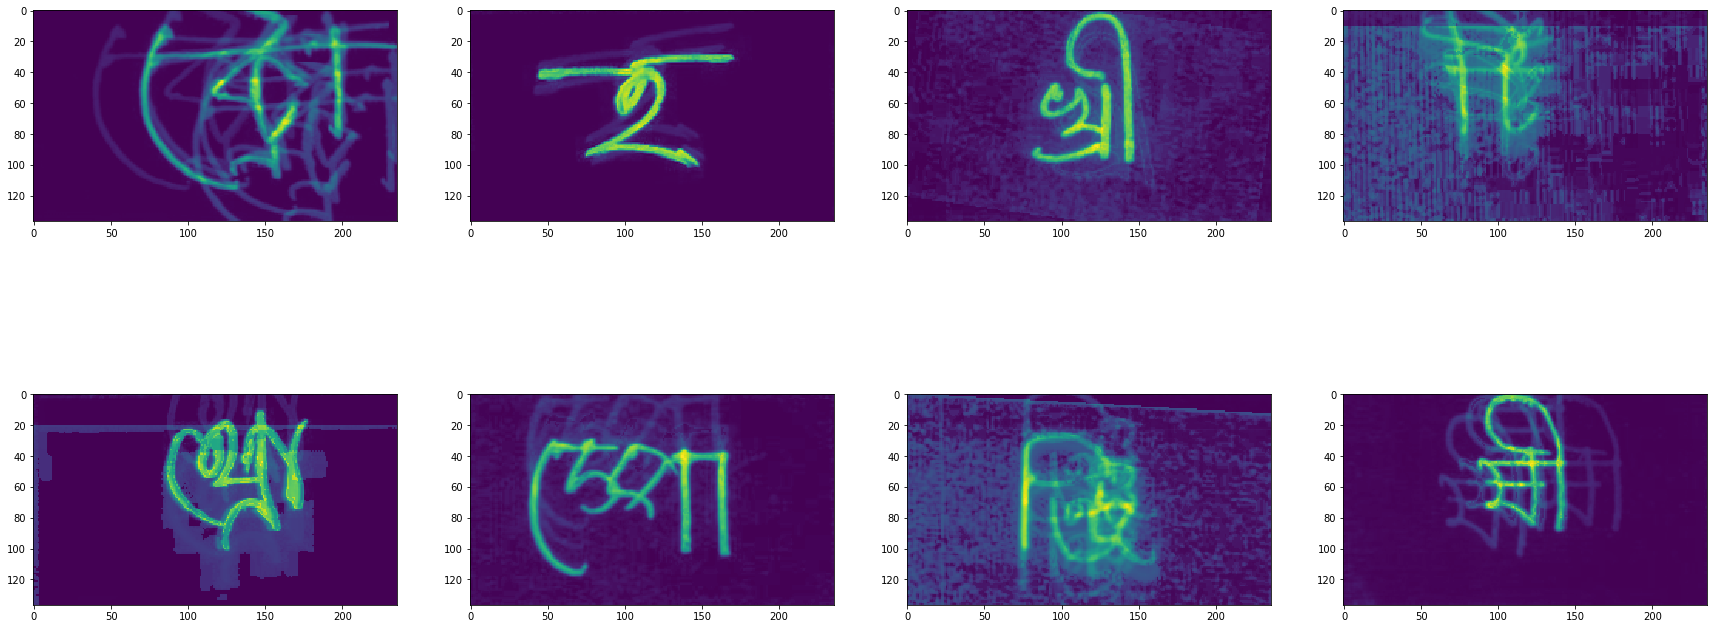

In [89]:
aug2 = albu.Compose([
    RandomAugMix(severity=5, width=5, alpha=5, p=1.),
])
aug_imgs = [aug2(image=img)['image'] for img in imgs]
show_imgs(aug_imgs)